In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on graph (the Graph DGMRF model) on the Wikipedia example

The original article is [here](https://proceedings.mlr.press/v162/oskarsson22a/oskarsson22a.pdf) and the code can be found [here](https://github.com/joeloskarsson/graph-dgmrf/blob/main/utils.py).

**Note: we were able to reproduce the results from the article with results on the same order of magnitude. However, we were restricted to a smaller number of layers since convergence issues of the variational distributions and CG algorithm happened when $L>2$** More fine-tuning in the optimization process seems required.

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## Load the wikipedia graph data

In [4]:
edges_mat = np.genfromtxt("./chameleon_edges.csv", delimiter=",", skip_header=1).astype(np.int32)
y = np.log(np.genfromtxt("./chameleon_target.csv", delimiter=",", skip_header=1) + 1e-6)[:, 1]

N = y.shape[0]

Convert the edge list to adjacency matrix

In [5]:
def update_adjacency_matrix(adjacency_matrix, edge):
    i, j = edge
    adjacency_matrix = adjacency_matrix.at[i, j].set(1)
    adjacency_matrix = adjacency_matrix.at[j, i].set(1)
    return adjacency_matrix, None

def edge_list_to_adjacency_matrix(edge_list, num_nodes):
    edge_array = jnp.array(edge_list)
    adjacency_matrix = jnp.zeros((num_nodes, num_nodes), dtype=jnp.int8)
    adjacency_matrix, _ = jax.lax.scan(update_adjacency_matrix, adjacency_matrix, edge_array)

    return adjacency_matrix

In [6]:
with jax.default_device(cpu_device):
    A = edge_list_to_adjacency_matrix(edges_mat, y.shape[0])
A = jax.device_put(A, gpu_device)

**Note that we skip the preprocesing step in this quick reproducting test** (see [original code](https://github.com/joeloskarsson/graph-dgmrf/blob/4c640b3eba025fdfdec8db977ca0f484748737d1/data_loading/wiki.py#L41))

Compute the diagonal of the degree matrix

In [7]:
D = jnp.sum(A, axis=1).astype(jnp.int32)

As stated in the article, 50% of nodes will be unobserved, randomly and uniformly chosen

In [8]:
mask = jnp.zeros_like(y)
key, subkey = jax.random.split(key, 2)
idx_unobserved = jax.random.choice(subkey, jnp.arange(y.shape[0]), shape=(y.shape[0] // 2,), replace=False)
mask = mask.at[idx_unobserved].set(1)
y = jnp.where(mask == 0, y, 0)

Optionally add noise

In [9]:
true_sigma_noise = 0.0001
key, subkey = jax.random.split(key, 2)
y = y + jax.random.normal(subkey, y.shape) * true_sigma_noise

## Define the DGMRF components

In [10]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_adjacency_matrix_lattice

**Similarly to the notebook presenting the graph DGMRF for a regular lattice, convergence problems happened for $L>2$**

In [11]:
L = 2
Nq = 10

In [12]:
y = y.flatten()
mask = mask.flatten()

In [13]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False,
)

dgmrf_params, dgmrf_static = eqx.partition(dgmrf, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!

Instanciate the variational distribution

In [14]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=N, key=subkey1)
# q_phi = FactorizedS(
#     N=N,
#     dgmrf_args=(subkey1, 1),
#     dgmrf_kwargs= {
#         "A_D":(A, D),
#         "log_det_method":"eigenvalues"
#     },
#     key=subkey2
# )
q_phi_params, q_phi_static = eqx.partition(q_phi, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!

## Variational inference to compute model parameters

In [15]:
key, subkey1, subkey2 = jax.random.split(key, 3)
params_init = {
    "dgmrf":dgmrf_params,
    "q_phi":q_phi_params,
    "log_sigma":jnp.log(true_sigma_noise)
}
static = {
    "dgmrf": dgmrf_static,
    "q_phi": q_phi_static
}


In [16]:
n_iter = 2000
lr_graph = 1e-2

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    {'dgmrf':"dgmrf", 'log_sigma':'log_sigma', 'q_phi':'q_phi'} # This what would be returned by the label_fn; i.e. this is the correct syntax when directly giving labels and when params is dict
)
opt_state = tx.init(params_init)

In [17]:
dgmrf = eqx.combine(params_init["dgmrf"], static["dgmrf"])

In [18]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

key, subkey = jax.random.split(key, 2)
params_final, loss_val = train_loop(dgmrf_elbo, y, n_iter, params_init, static, tx, opt_state, subkey, N, Nq, mask=mask)

  0%|          | 0/2000 [00:00<?, ?it/s]

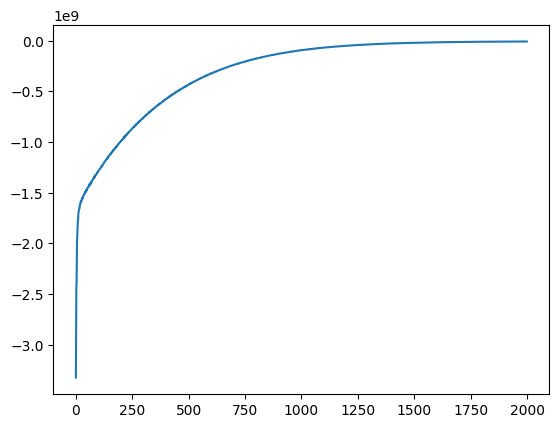

In [19]:
plt.plot(-loss_val)
plt.show()

The means of the variational distribution will be the inferred values as a first approximation

In [20]:
rmse_nu_phi = jnp.sqrt(jnp.mean((params_final["q_phi"].params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)

RMSE with the means of the variational distribution 2.0239422
